<a href="https://colab.research.google.com/github/Fabrizio211/64061_AdvancedMachineLearning_ffiorini/blob/main/Assignment_1_AML_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning
# Assignment 1 - Neural Network
### Fabrizio Fiorini

***

## Instructions

In this assignment, you will accomplish the following:
1. Modify an existing neural network model to improve performance
2. Explain how different approaches affect the performance of the model
For the IMDB example that we discussed in class, do the following:
3. You used two hidden layers. Try using one or three hidden layers, and see how doing so 
affects validation and test accuracy.
4. Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so 
on.
5. Try using the mse loss function instead of binary_crossentropy.
4. Try using the tanh activation (an activation that was popular in the early days of neural 
networks) instead of relu.
5. Use any technique we studied in class, and these include regularization, dropout, etc., to 
get your model to perform better on validation



## The IMDB dataset

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

The "IMDB dataset" is a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras and it has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

This is a perfect example of a binary classification application. The goal is to 

Throughtout the model, we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

In [ ]:
install.packages("keras")
library(keras)
imdb <- dataset_imdb(num_words = 10000)

train_data <- imdb$train$x
train_labels <- imdb$train$y
test_data <- imdb$test$x
test_labels <- imdb$test$y

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":


In [ ]:
str(train_data[[1]])

train_labels[[1]]

 int [1:218] 1 14 22 16 43 530 973 1622 1385 65 ...


[1] 1

## Preparing the data


Since we can't feed lists of integers into a neural network, we have to turn your lists into tensors. One-hot-encoding is used here to convert our lists into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[3, 5]` into a 10,000-dimensional vector that would be all zeros except for indices 3 and 5, which would be ones.

In [ ]:
vectorize_sequences <- function(sequences, dimension = 10000) {
  # Create an all-zero matrix of shape (len(sequences), dimension)
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    # Sets specific indices of results[i] to 1s
    results[i, sequences[[i]]] <- 1
  results
}
# Our vectorized training data
x_train <- vectorize_sequences(train_data)
# Our vectorized test data
x_test <- vectorize_sequences(test_data)

In [ ]:

str(x_train[1,])

 num [1:10000] 1 1 0 1 1 1 1 1 1 0 ...



We should also vectorize our labels, which is straightforward:


In [ ]:
# Our vectorized labels
y_train <- as.numeric(train_labels)
y_test <- as.numeric(test_labels)


Now our data is ready to be fed into a neural network.

## Building our network

Now we have to provide a structure for our network. 
Specifically, the model's architecture is based on the following elements:
* Number of hidden layers.
* Number of units for each layer.
* Activation function.

A type of network that performs well on this problem is a simple stack of fully connected ("dense") layers like the following: `layer_dense(units = 16, activation = "relu")`.

For the moment, let us use two intermediate layers with 16 units, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The activation functions used here are `relu` for the intermediate layers and `sigmoid` for the last one. This last activation function is required to obtain a probability (a score between 0 and 1 indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive) as the model output. Later, we will move from these choices aiming at improve our model's performance.

Each such dense layer with a `relu` activation implements the following chain of tensor operations: `output = relu(dot(W, input) + b)`

Here's the Keras implementation:

In [ ]:
#library(keras)
model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

Once the model architecture is set, we have to specify other three fundamental elements that will give us the ability to evaluate the model performance and improve it by tuning  :
* Loss function.
* Loss metric.
* Optimizer.

Since we are facing a binary classification problem and the output of our network is a probability, it is recommended the use of the `binary_crossentropy` loss. It measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions. We choose `rmsprop` as optimizer. Lastly, our metric will be the accuracy of the prediction.

In [ ]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [ ]:
val_indices <- 1:10000
x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]
y_val <- y_train[val_indices]
partial_y_train <- y_train[-val_indices]

It is time to train our model. Let us set epochs = 20 (20 iterations over all samples in the `x_train` and `y_train` tensors), and use a batch size of 512 samples. Also, we want to monitor loss and accuracy on the 10,000 samples that we set apart as validation set.

In [ ]:
history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
#results <- model %>% evaluate(x_val, y_val)

#results

Note that the call to `fit()` returns a `history` object. Let's take a look at it:

In [ ]:
str(history)

List of 2
 $ params :List of 3
  ..$ verbose: int 1
  ..$ epochs : int 20
  ..$ steps  : int 30
 $ metrics:List of 4
  ..$ loss        : num [1:20] 0.531 0.317 0.229 0.179 0.147 ...
  ..$ accuracy    : num [1:20] 0.772 0.902 0.928 0.942 0.953 ...
  ..$ val_loss    : num [1:20] 0.405 0.313 0.279 0.316 0.277 ...
  ..$ val_accuracy: num [1:20] 0.859 0.886 0.891 0.873 0.89 ...
 - attr(*, "class")= chr "keras_training_history"



The `history` object includes various parameters used to fit the model (`history$params`) as well as data for each of the metrics being monitored (`history$metrics`).

We can plot the `history` to visualize the training and validation metrics by epoch:

`geom_smooth()` using formula 'y ~ x'



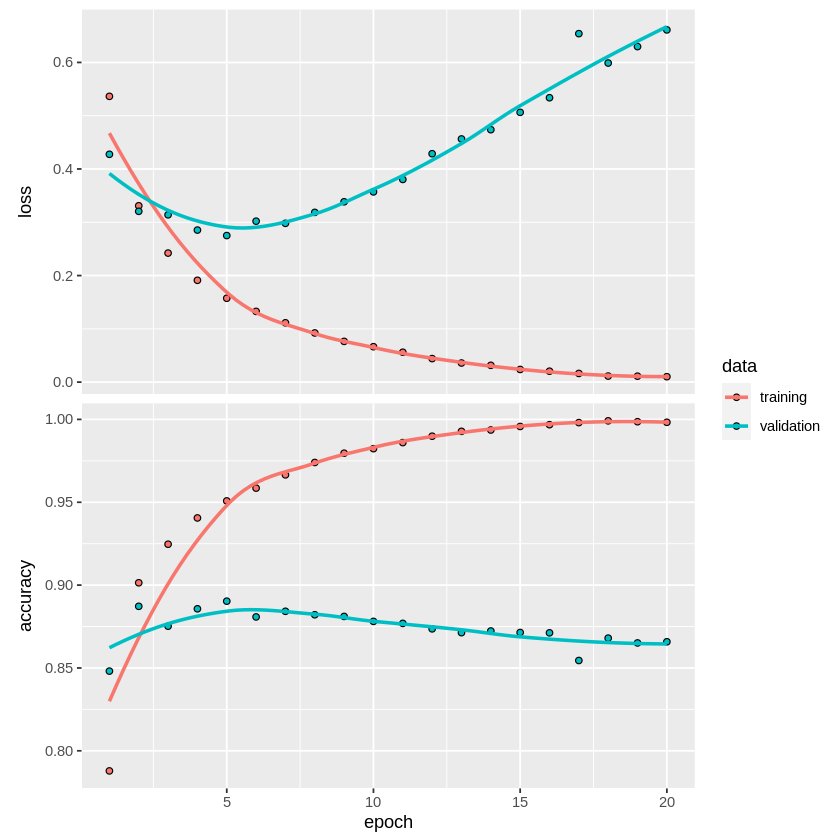

In [ ]:
plot(history)

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when running a gradient-descent optimization -- the quantity you're trying to minimize should be less with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. From the chart we can clearly see that the model starts to _overfitting_ after the second epoch. It is learning representations that are specific to the training data and don't generalize to unseen data.

In this case, to prevent overfitting, you could stop training after 3 epochs. Let's train a new network from scratch for 4 epochs and then evaluate it on the test data.

In [ ]:
model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")
model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

model %>% fit(x_train, y_train, epochs = 4, batch_size = 512)

results <- model %>% evaluate(x_test, y_test)

results

loss  accuracy 
0.2882504 0.8856000

Our model achieves an accuracy of 88%.

## Using a trained network to generate predictions on new data

After having trained a network, we can now use it to make predictions. We can generate the likelihood of reviews being positive by using the `predict` function.

In [ ]:
model %>% predict(x_test[1:10,])

0.17623568
0.99934089
0.69764686
0.65464401
0.92946774
0.73973829
0.99896562
0.01033852
0.94269145
0.98287809


As you can see, the network is very confident for some samples (0.99 or more, or 0.02 or less) but less confident for others. 

## Further experiments

Let us now develop even further our model with the goal of increasing the overall performance. To achieve this, we will change the following parameters one at a time and run again the entire algorithm to check whether the accuracy improve.

In the following, we are going to test different variations (modvar, model variation) of the neural network we developed. An explaination of the effects of the changes is provided.n try to modify the .



* One way we can try to improve our model is to modify the architecture of the neural network by changing the number of hidden layers and the units. In modvar1 we used only one hidden layer. In modvar2 we used three hidden layer. In modvar3 we used our original model with 2 layers but with more units (64). Finally, in modvar4 we choosed less units (8).
* For each of the models above, both the crossentropy and the mean squared error have been used as loss function.
* modvar 5 uses a different activation function called `tanh`, that was popular in the early days of neural networks.

In [ ]:
modvar1 <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 1, activation = "sigmoid")

modvar1a <- modvar1
modvar1b <- modvar1


modvar1a %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

val_indices <- 1:10000
x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]
y_val <- y_train[val_indices]
partial_y_train <- y_train[-val_indices]

history1a <- modvar1a %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history1a)

modvar1b %>% compile(
  optimizer = "rmsprop",
  loss = "mse",
  metrics = c("accuracy")
)

history1b <- modvar1b %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history1b)


In [ ]:
modvar1a %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res1a <- modvar1a %>% evaluate(x_test, y_test)
res1a

modvar1b %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res1b <- modvar1b %>% evaluate(x_test, y_test)
res1b

loss  accuracy 
0.1271795 0.8532800

loss  accuracy 
0.1273661 0.8534000

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



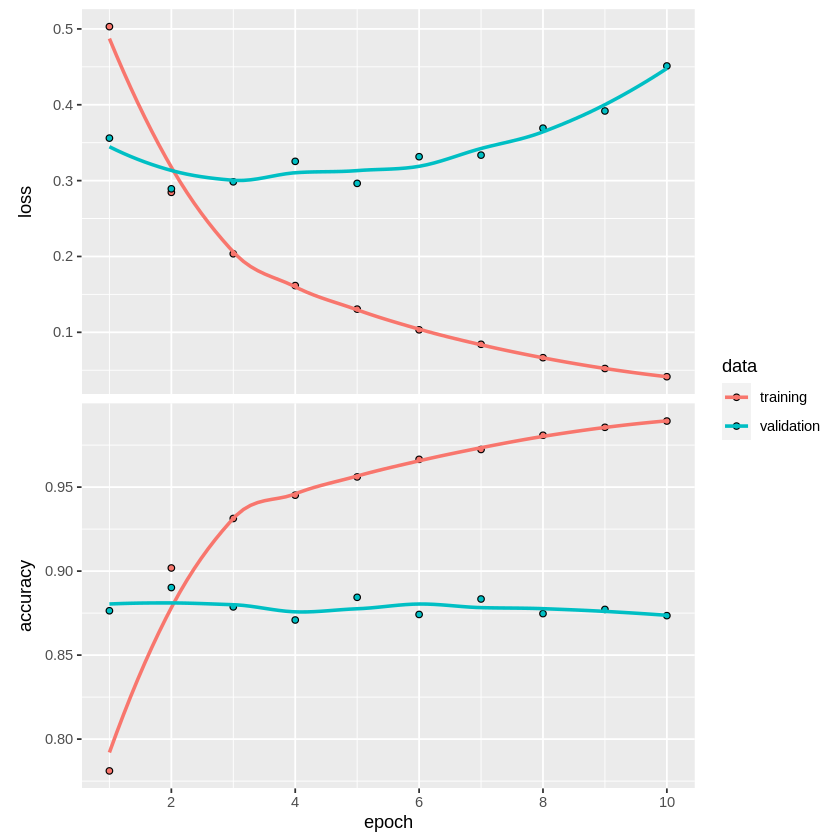

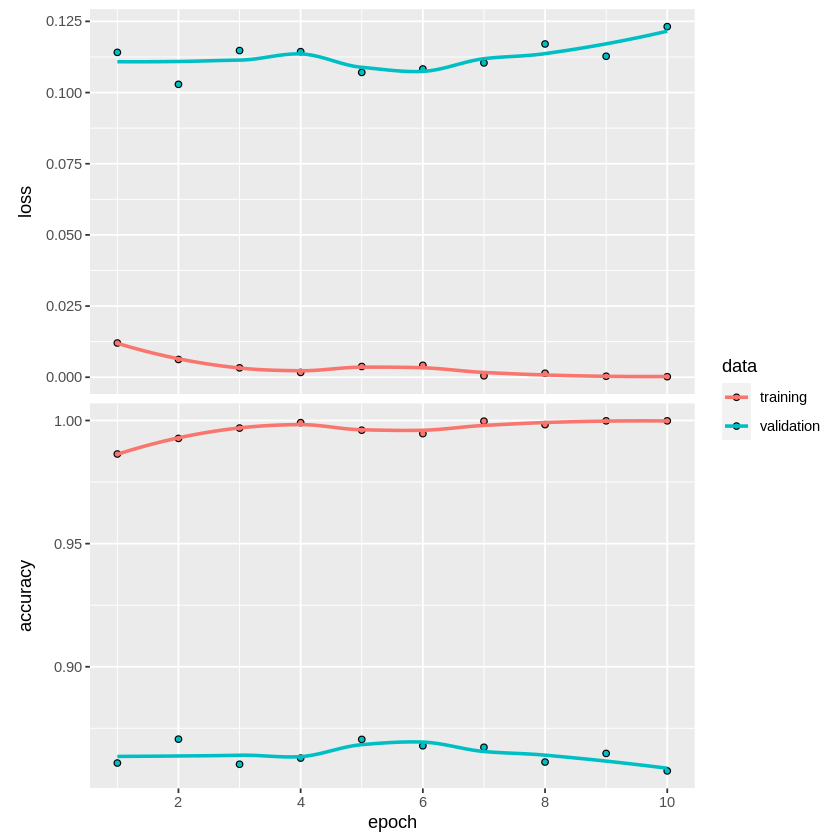

In [ ]:
modvar2 <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

modvar2a <- modvar2
modvar2b <- modvar2


modvar2a %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history2a <- modvar2a %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history2a)

modvar2b %>% compile(
  optimizer = "rmsprop",
  loss = "mse",
  metrics = c("accuracy")
)

history2b <- modvar2b %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history2b)


In [ ]:
modvar2a %>% fit(x_train, y_train, epochs = 2, batch_size = 512)
res2a <- modvar2a %>% evaluate(x_test, y_test)
res2a

modvar2b %>% fit(x_train, y_train, epochs = 2, batch_size = 512)
res2b <- modvar2b %>% evaluate(x_test, y_test)
res2b

loss  accuracy 
0.1190407 0.8582000

loss  accuracy 
0.1190879 0.8584000

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



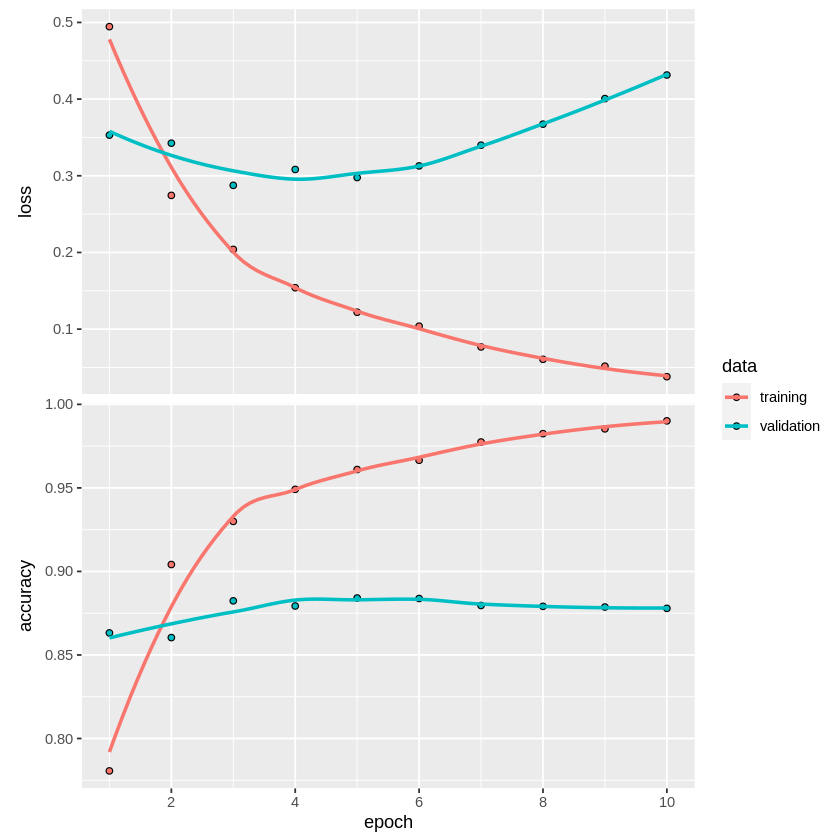

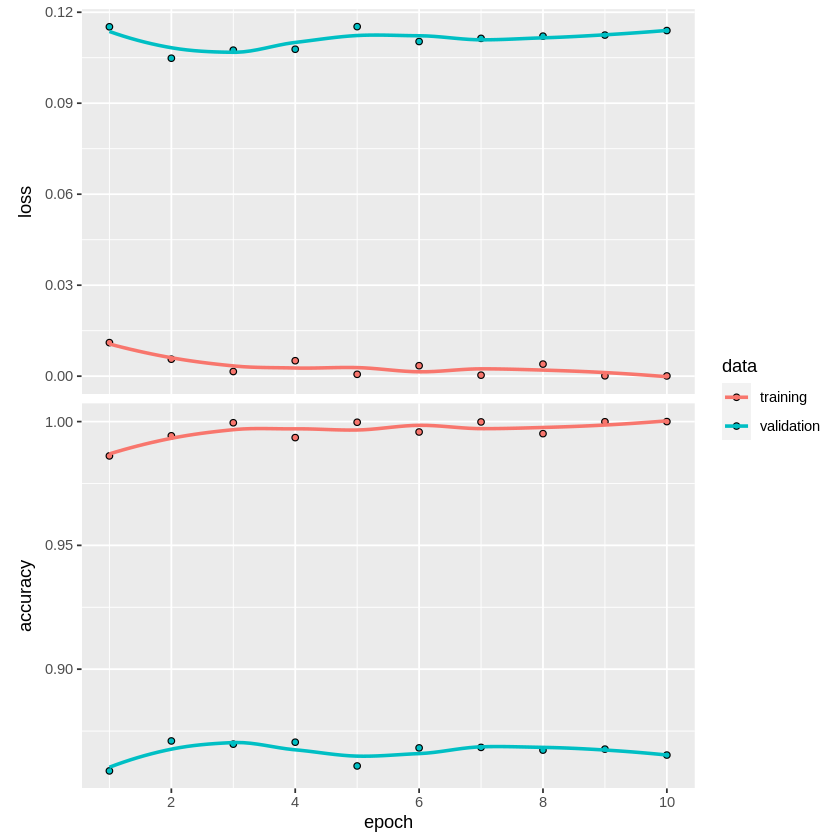

In [ ]:
modvar3 <- keras_model_sequential() %>% 
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 64, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

modvar3a <- modvar3
modvar3b <- modvar3


modvar3a %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history3a <- modvar3a %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history3a)

modvar3b %>% compile(
  optimizer = "rmsprop",
  loss = "mse",
  metrics = c("accuracy")
)

history3b <- modvar3b %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history3b)

In [ ]:
modvar3a %>% fit(x_train, y_train, epochs = 2, batch_size = 512)
res3a <- modvar3a %>% evaluate(x_test, y_test)
res3a

modvar3b %>% fit(x_train, y_train, epochs = 2, batch_size = 512)
res3b <- modvar3b %>% evaluate(x_test, y_test)
res3b

ERROR: ignored

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



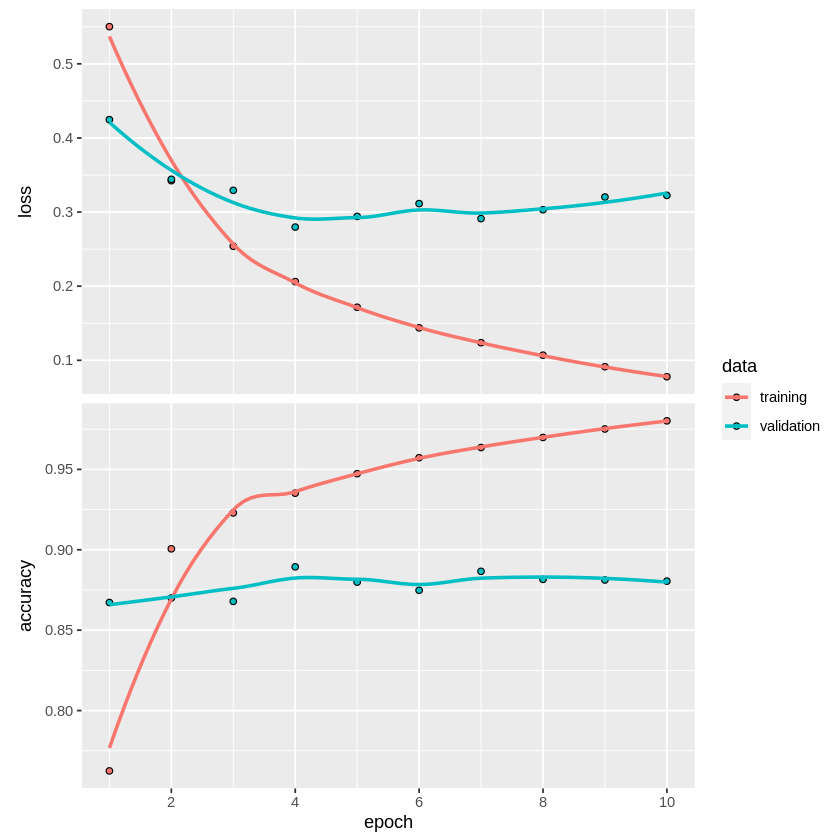

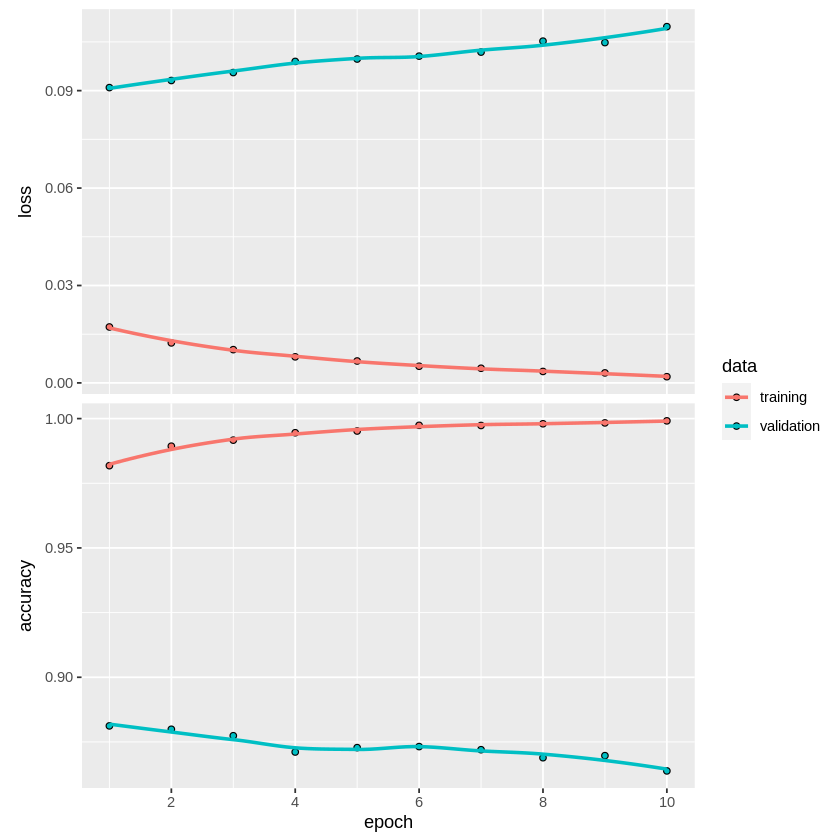

In [ ]:
modvar4 <- keras_model_sequential() %>% 
  layer_dense(units = 8, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 8, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

modvar4a <- modvar4
modvar4b <- modvar4


modvar4a %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history4a <- modvar4a %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history4a)

modvar4b %>% compile(
  optimizer = "rmsprop",
  loss = "mse",
  metrics = c("accuracy")
)

history4b <- modvar4b %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history4b)

In [ ]:
modvar4a %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res4a <- modvar4a %>% evaluate(x_test, y_test)
res4a

modvar4b %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res4b <- modvar4b %>% evaluate(x_test, y_test)
res4b

loss  accuracy 
0.1122285 0.8610000

loss  accuracy 
0.1191411 0.8558400

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



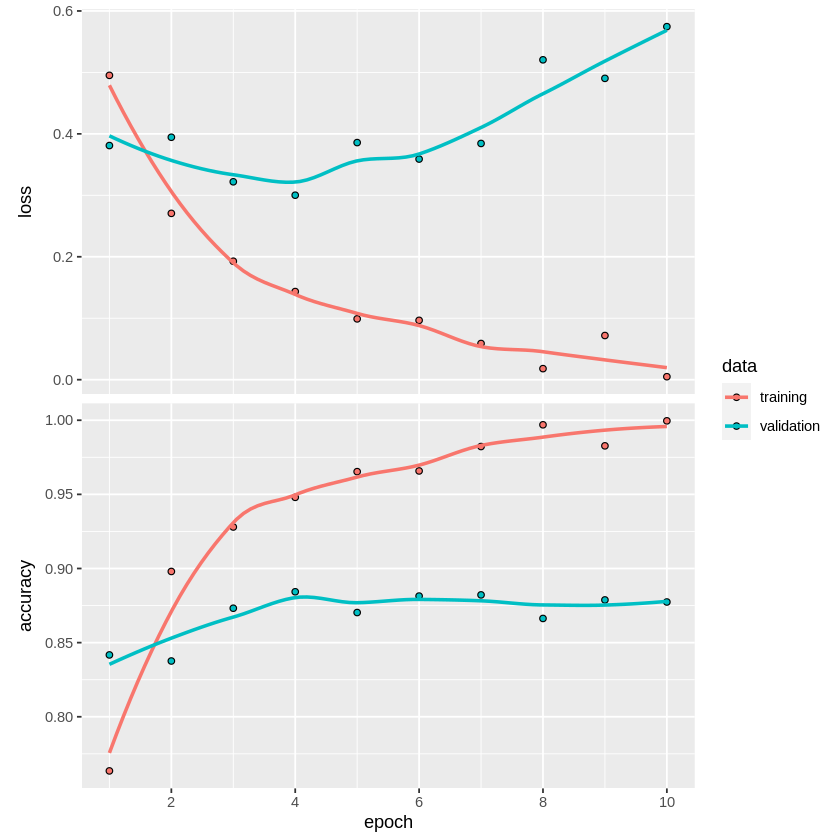

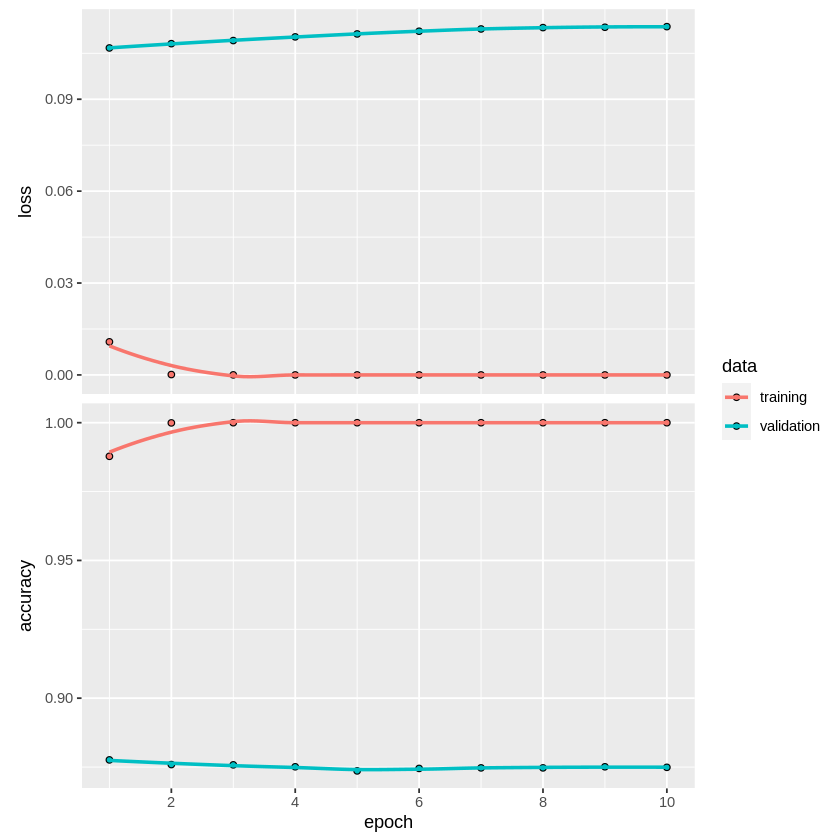

In [ ]:
modvar5 <- keras_model_sequential() %>% 
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 64, activation = "relu") %>% 
  layer_dense(units = 64, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

modvar5a <- modvar5
modvar5b <- modvar5


modvar5a %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history5a <- modvar5a %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history5a)

modvar5b %>% compile(
  optimizer = "rmsprop",
  loss = "mse",
  metrics = c("accuracy")
)

history5b <- modvar5b %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)
plot(history5b)

In [ ]:
modvar5a %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res5a <- modvar5a %>% evaluate(x_test, y_test)
res5a

modvar5b %>% fit(x_train, y_train, epochs = 4, batch_size = 512)
res5b <- modvar5b %>% evaluate(x_test, y_test)
res5b

loss  accuracy 
0.1148733 0.8659200

loss  accuracy 
0.1119328 0.8679600

The simplest way to prevent overfitting is to reduce the size of the model: the number
of learnable parameters in the model (which is determined by the number of layers
and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model’s capacity.
Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the
correct model size for your data. The general workflow to find an appropriate model
size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.
 the smaller network starts overfitting later than the reference network
(after six epochs rather than four), and its performance degrades more slowly once it
starts overfitting.
The bigger network starts overfitting almost immediately, after just one epoch, and it
overfits much more severely. Its validation loss is also noisier